In [ ]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
import torch

Loading the dataset

In [ ]:
users = pd.read_csv("rating_final.csv")
recipes_c = pd.read_csv("chefmozcuisine.csv")

In [ ]:
recipes_p = pd.read_csv("chefmozparking.csv")
recipes_a = pd.read_csv("chefmozaccepts.csv")

In [ ]:
recipes = pd.merge(pd.merge(recipes_a,recipes_p,on='placeID'),recipes_c,on='placeID')

In [ ]:
users.columns

Index(['userID', 'placeID', 'rating', 'food_rating', 'service_rating'], dtype='object')

In [ ]:
recipes.columns

Index(['placeID', 'Rpayment', 'parking_lot', 'Rcuisine'], dtype='object')

Preprocessing the dataset


In [ ]:
users["userID"] = users["userID"].apply(lambda x: f"user_{x}")
users["placeID"] = users["placeID"].apply(lambda x: f"rest_{x}")
users["rating"] = users["rating"].apply(lambda x: float(x))

In [ ]:
recipes["placeID"] = recipes["placeID"].apply(lambda x: f"rest_{x}")

In [ ]:
recipes

,placeID,Rpayment,parking_lot,Rcuisine
0,rest_135110,cash,none,Spanish
1,rest_135110,VISA,none,Spanish
2,rest_135110,MasterCard-Eurocard,none,Spanish
3,rest_135110,American_Express,none,Spanish
4,rest_135110,bank_debit_cards,none,Spanish
...,...,...,...,...
1378,rest_132012,bank_debit_cards,street,Dutch-Belgian
1379,rest_132012,Diners_Club,public,French
1380,rest_132012,Diners_Club,public,Dutch-Belgian
1381,rest_132012,Diners_Club,street,French


Used cuisine, payment and parking lot information and converted to one-hot encoded vectors


In [ ]:
recipe_tags = []
for val in recipes.Rcuisine:
  for v in val.split(','):
    recipe_tags.append(v)
# recipe_tags = set(recipe_tags)

In [ ]:
for val in recipes.Rpayment:
  for v in val.split(','):
    recipe_tags.append(v)
# recipe_tags = set(recipe_tags)

In [ ]:
recipe_tags

In [ ]:
recipes['parking_lot'] = recipes['parking_lot'].fillna('NA')

In [ ]:
for val in recipes.parking_lot:
  # for v in val.split(','):
    recipe_tags.append(val)
recipe_tags = set(recipe_tags)

In [ ]:
recipe_tags

In [ ]:
for tag in recipe_tags:
    recipes[tag] = recipes["Rcuisine"].apply(
        lambda values: int(tag in values.split("|"))
    )

In [ ]:
recipes

,placeID,Rpayment,parking_lot,Rcuisine,American_Express,public,cash,Spanish,Contemporary,Seafood,...,Deli-Sandwiches,Burgers,Japan_Credit_Bureau,Diners_Club,African,Bakery,Japanese,bank_debit_cards,Pizzeria,Carte_Blanche
0,rest_135110,cash,none,Spanish,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,rest_135110,VISA,none,Spanish,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,rest_135110,MasterCard-Eurocard,none,Spanish,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,rest_135110,American_Express,none,Spanish,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,rest_135110,bank_debit_cards,none,Spanish,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,rest_132012,bank_debit_cards,street,Dutch-Belgian,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1379,rest_132012,Diners_Club,public,French,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1380,rest_132012,Diners_Club,public,Dutch-Belgian,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1381,rest_132012,Diners_Club,street,French,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_group = users.groupby("userID")

ratings_data = pd.DataFrame(
    data={
        "userID": list(ratings_group.groups.keys()),
        "placeID": list(ratings_group.placeID.apply(list)),
        "ratings": list(ratings_group.rating.apply(list))
    }
)

In [ ]:
ratings_data

,userID,placeID,ratings
0,user_U1001,"[rest_132830, rest_132825, rest_135085, rest_1...","[1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0]"
1,user_U1002,"[rest_132921, rest_135062, rest_135106, rest_1...","[2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, ..."
2,user_U1003,"[rest_135064, rest_132825, rest_135075, rest_1...","[0.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, ..."
3,user_U1004,"[rest_135060, rest_135028, rest_135106, rest_1...","[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]"
4,user_U1005,"[rest_135050, rest_135076, rest_132830, rest_1...","[1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0]"
...,...,...,...
133,user_U1134,"[rest_135047, rest_135026, rest_135044, rest_1...","[1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
134,user_U1135,"[rest_135085, rest_135106, rest_135052, rest_1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
135,user_U1136,"[rest_135074, rest_132862, rest_132921, rest_1...","[1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, ..."
136,user_U1137,"[rest_132951, rest_135085, rest_132834, rest_1...","[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ..."


Creating the restaurant sequences per user ( 4 recipes per user)

In [ ]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.placeID = ratings_data.placeID.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)
# del ratings_data["timestamps"]

In [ ]:
ratings_data

,userID,placeID,ratings
0,user_U1001,"[[rest_132830, rest_132825, rest_135085, rest_...","[[1.0, 2.0, 0.0, 1.0], [0.0, 1.0, 1.0, 1.0], [..."
1,user_U1002,"[[rest_132921, rest_135062, rest_135106, rest_...","[[2.0, 1.0, 1.0, 2.0], [1.0, 2.0, 1.0, 2.0], [..."
2,user_U1003,"[[rest_135064, rest_132825, rest_135075, rest_...","[[0.0, 2.0, 2.0, 1.0], [2.0, 1.0, 0.0, 2.0], [..."
3,user_U1004,"[[rest_135060, rest_135028, rest_135106, rest_...","[[1.0, 2.0, 2.0, 2.0], [2.0, 2.0, 2.0, 2.0], [..."
4,user_U1005,"[[rest_135050, rest_135076, rest_132830, rest_...","[[1.0, 2.0, 1.0, 2.0], [1.0, 2.0, 1.0, 1.0], [..."
...,...,...,...
133,user_U1134,"[[rest_135047, rest_135026, rest_135044, rest_...","[[1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 2.0, 2.0], [..."
134,user_U1135,"[[rest_135085, rest_135106, rest_135052, rest_...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
135,user_U1136,"[[rest_135074, rest_132862, rest_132921, rest_...","[[1.0, 2.0, 2.0, 1.0], [2.0, 1.0, 2.0, 1.0], [..."
136,user_U1137,"[[rest_132951, rest_135085, rest_132834, rest_...","[[2.0, 2.0, 2.0, 2.0], [2.0, 2.0, 0.0, 2.0], [..."


In [ ]:
ratings_data_movies = ratings_data[["userID", "placeID"]].explode(
    "placeID", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed[ratings_data_transformed['placeID'].notna()]
# ratings_data_transformed = ratings_data_transformed.join(
#     users.set_index("user_id"), on="user_id"
# )
# ratings_data_transformed.recipe_ids = ratings_data_transformed.recipe_ids.apply(
#     lambda x: ",".join(x)
# )

ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)


ratings_data_transformed.rename(
    columns={"placeID": "sequence_recipe_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [ ]:
ratings_data_transformed

,userID,sequence_recipe_ids,sequence_ratings
0,user_U1001,"[rest_132830, rest_132825, rest_135085, rest_1...","1.0,2.0,0.0,1.0"
1,user_U1001,"[rest_135085, rest_135040, rest_135039, rest_1...","0.0,1.0,1.0,1.0"
2,user_U1001,"[rest_135039, rest_135045, rest_135033, rest_1...","1.0,1.0,1.0,2.0"
3,user_U1001,"[rest_135045, rest_135033, rest_135025, rest_1...","1.0,1.0,2.0,1.0"
4,user_U1002,"[rest_132921, rest_135062, rest_135106, rest_1...","2.0,1.0,1.0,2.0"
...,...,...,...
540,user_U1137,"[rest_135058, rest_135059, rest_135062, rest_1...","0.0,2.0,2.0,2.0"
541,user_U1137,"[rest_135062, rest_132825, rest_132723, rest_1...","2.0,2.0,2.0,2.0"
542,user_U1137,"[rest_132723, rest_132755, rest_135042, rest_1...","2.0,2.0,2.0,2.0"
543,user_U1137,"[rest_135042, rest_132884, rest_135049, rest_1...","2.0,2.0,2.0,2.0"


Dividing into training and test set

In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

In [ ]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "userID": list(users.userID.unique()),
    "placeID": list(users.placeID.unique()),
    # "sex": list(users.sex.unique()),
    # "age_group": list(users.age_group.unique()),
    # "occupation": list(users.occupation.unique()),
}

# USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["Rcuisine"]

In [ ]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        recipe_ids_string = features["sequence_recipe_ids"]
        sequence_recipe_ids = tf.strings.split(recipe_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_recipe_id"] = sequence_recipe_ids[:, -1]
        features["sequence_recipe_ids"] = sequence_recipe_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

Intializing the model

In [ ]:
def create_model_inputs():
    return {
        "userID": layers.Input(name="userID", shape=(1,), dtype=tf.string),
        "sequence_recipe_ids": layers.Input(
            name="sequence_recipe_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_recipe_id": layers.Input(
            name="target_recipe_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        # "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        # "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        # "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

Encoding input features

In [ ]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=False,
    include_recipe_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("userID")
    # if include_user_features:
        # other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=1)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    recipe_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["placeID"]
    recipe_embedding_dims = int(math.sqrt(len(recipe_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    recipe_index_lookup = StringLookup(
        vocabulary=recipe_vocabulary,
        mask_token=None,
        num_oov_indices=1,
        name="recipe_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    recipe_embedding_encoder = layers.Embedding(
        input_dim=len(recipe_vocabulary),
        output_dim=recipe_embedding_dims,
        name=f"recipe_embedding",
    )
    # Create a vector lookup for movie genres.
    tag_vectors = recipes[recipe_tags].to_numpy()
    recipe_tags_lookup = layers.Embedding(
        input_dim=tag_vectors.shape[0],
        output_dim=tag_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(tag_vectors),
        trainable=False,
        name="tags_vector",
    )
    # Create a processing layer for genres.
    recipe_embedding_processor = layers.Dense(
        units=recipe_embedding_dims,
        activation="relu",
        name="process_recipe_embedding_with_tags",
    )

    ## Define a function to encode a given movie id.
    def encode_recipe(recipe_id):
        # Convert the string input values into integer indices.
        recipe_idx = recipe_index_lookup(recipe_id)
        recipe_embedding = recipe_embedding_encoder(recipe_idx)
        encoded_recipe = recipe_embedding
        if include_recipe_features:
            recipe_tags_vector = recipe_tags_lookup(recipe_idx)
            encoded_recipe = recipe_embedding_processor(
                layers.concatenate([recipe_embedding, recipe_tags_vector])
            )
        return encoded_recipe

    ## Encoding target_movie_id
    target_recipe_id = inputs["target_recipe_id"]
    encoded_target_recipe = encode_recipe(target_recipe_id)

    ## Encoding sequence movie_ids.
    sequence_recipes_ids = inputs["sequence_recipe_ids"]
    encoded_sequence_recipes = encode_recipe(sequence_recipes_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=recipe_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_recipes_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_recipes + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_recipe in tf.unstack(
        encoded_sequence_recipes_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_recipe, 1))
    encoded_transformer_features.append(encoded_target_recipe)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features

Creating the model

In [ ]:
include_user_id = False
include_user_features = False
include_recipe_features = True

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_recipe_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

Setting the metrics - NDCG and MRR and loss function - MAE for training the model

In [ ]:
# !pip install tensorflow_ranking

In [ ]:
import tensorflow_ranking as tfr
from keras.metrics import top_k_categorical_accuracy,MeanAbsoluteError

eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=False),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=False)
]

model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),'top_k_categorical_accuracy',eval_metrics],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)
# Fit the model with the training data.
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset)

# Read the test data.

# Evaluate the model on the test data.
vals = model.evaluate(test_dataset, verbose=0)
print(vals)
# print(f"Test MAE: {round(rmse, 3)}")


Epoch 1/10
2/2 [==============================] - 4s 1s/step - loss: 6.7491 - mean_absolute_error: 2.1281 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7904 - metric/mrr: 0.7904 - val_loss: 1.2955 - val_mean_absolute_error: 1.0109 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7692 - val_metric/mrr: 0.7692
Epoch 2/10
2/2 [==============================] - 0s 107ms/step - loss: 2.7687 - mean_absolute_error: 1.4303 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7904 - metric/mrr: 0.7904 - val_loss: 0.9409 - val_mean_absolute_error: 0.8280 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7692 - val_metric/mrr: 0.7692
Epoch 3/10
2/2 [==============================] - 0s 93ms/step - loss: 1.4620 - mean_absolute_error: 1.0097 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.7904 - metric/mrr: 0.7904 - val_loss: 0.8430 - val_mean_absolute_error: 0.7789 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.7692 - val_metric/mrr: 0.7692
Ep

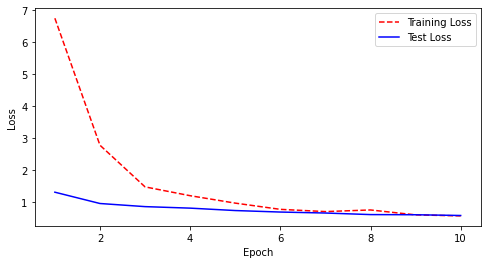

In [ ]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Evaluating the test set

In [ ]:
model.evaluate(test_dataset, verbose=0)

# [0.5649999380111694,
#  0.6390259861946106,
#  1.0,
#  0.7692307829856873,
#  0.7692307829856873]

[0.5649999380111694,
 0.6390259861946106,
 1.0,
 0.7692307829856873,
 0.7692307829856873]